In [18]:
## Collect initial time
import time
start_time = time.time()
print ('Training start')

## Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
import pickle
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

## Load trainning database
import os
path = "..."
os.chdir(path)
df = pd.read_csv("Data_Train\U_A_Train_All.csv")

# Training and validation data split
df_train, df_validation = train_test_split(df, test_size=0.30, shuffle=True)

X_train = df_train[["Uwall", "Uroof", "Uwind", "g_glass","Q_int","Tsp","ACH","SSEcrgd", "Rc", "HDD_crgd"]]
y_train = df_train['TB_crgd']

X_validation = df_validation[["Uwall", "Uroof", "Uwind", "g_glass","Q_int","Tsp","ACH","SSEcrgd", "Rc", "HDD_crgd"]]
y_validation = df_validation['TB_crgd']

# Train and test set are converted to DMatrix objects, as it is required by learning API.
train_dmatrix = xg.DMatrix(data = X_train, label = y_train)
validation_dmatrix = xg.DMatrix(data = X_validation, label = y_validation)

## XGBoost model development
# Define hyperparameter
params = { 'max_depth': [3, 6, 10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 200, 500],
           'colsample_bytree': [0.3, 0.5, 0.7]}
  
xgbr = xg.XGBRegressor(seed = 20)
optimizer = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_root_mean_squared_error',
                         verbose=1)
optimizer.fit(X_train, y_train)    

# Export trainned model
pickle.dump(optimizer, open('model_All-HDD_TB.pkl', 'wb'))

# Validate trainned model
pred = optimizer.predict(X_validation)

## Error Computation
rmse = np.sqrt(MSE(y_validation, pred))
mae = mean_absolute_error(y_validation, pred)
mape = mean_absolute_percentage_error(y_validation, pred)
print(f'MAE = {mae}')
print(f'MAPE = {mape}')
print(f'RMSE = {rmse}')

## Calculate total computation time (sourcing to error computing)
end_time = time.time()
duration = end_time - start_time
print ('Training duration: ', np.divide(duration, 60), 'minutes')

Training start
Fitting 5 folds for each of 81 candidates, totalling 405 fits
MAE = 0.44869035328110135
MAPE = 0.10512561368267259
RMSE = 0.6698362067560322
Training duration:  3.849061421553294 minutes


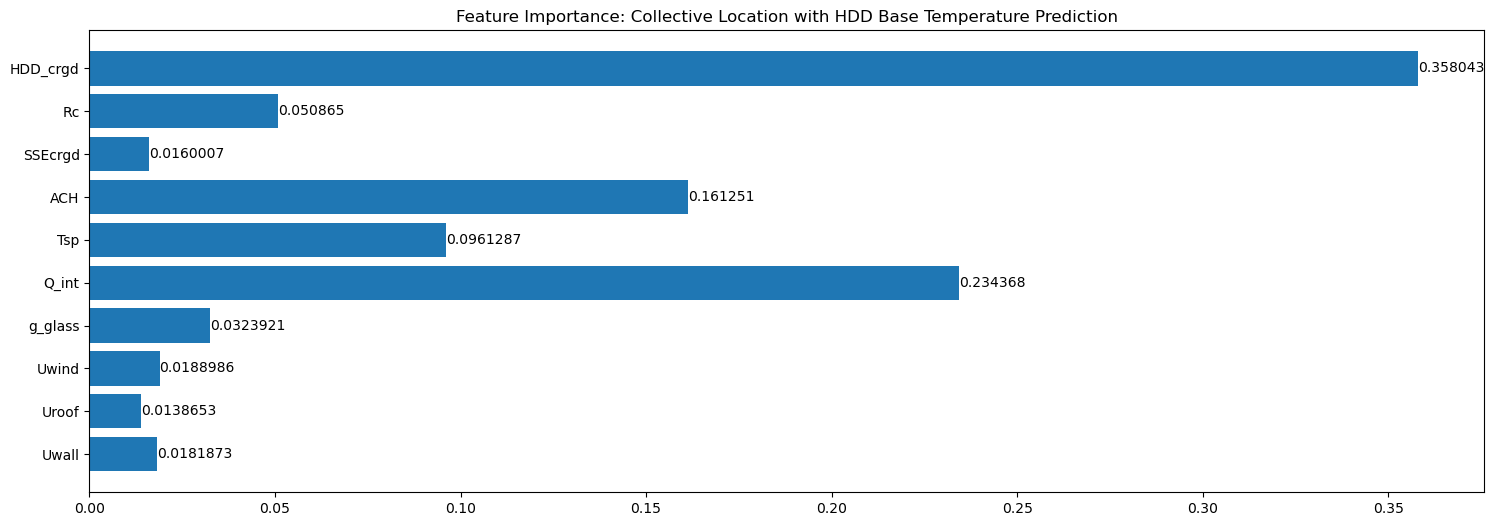

Feature importance figure is saved


In [19]:
## Feature Importance
import matplotlib.pyplot as plt

# Collect features and feature importance
Importance = optimizer.best_estimator_.feature_importances_
Feature = ["Uwall", "Uroof", "Uwind", "g_glass","Q_int","Tsp","ACH","SSEcrgd", "Rc", "HDD_crgd"]

# Generate plot
fig, ax = plt.subplots(figsize =(18,6))
hbar = plt.barh (Feature, Importance)
ax.bar_label(hbar)
plt.title("Feature Importance: Collective Location with HDD Base Temperature Prediction")
plt.show()

# Export graph
fig.savefig(r'Result\FeatureImportance_All-HDD_TB.png', format="png", dpi=800)
print ('Feature importance figure is saved')


In [23]:
## Error calculation section

# Check any duplicate value of the base temperature in the initial dataset
# Count the number of base temperature values
df2 = df.pivot_table(index = ['TB_crgd'], aggfunc ='size')
if len(df) == len(df2) :
    print("No duplicates found")
else:
    # The else is the preferred result for base temperature
    print("TB duplicated found, validation cases and prediction exported")
    df_validation.to_csv(r'Result\All-HDD_TB_validationCases.csv')
    print ("Export completed")

# Error calculation
RealTB = np.array(y_validation)
PredTB = np.array(pred) 
Error = np.subtract(y_validation, pred)

# Append HFArea, real and predicted demand
# Initial row sequence from y_validation is maintained
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    dframe = pd.DataFrame()
    dframe['Real TB'] = list(RealTB)
    dframe['Prediction'] = list(PredTB)
    dframe['Error'] = list(Error)
    
# Export prediction result
result = dframe
result.to_csv(r'Result\All-HDD_TB_train.csv')
print ('Prediction result is exported')

TB duplicated found, validation cases and prediction exported
Export completed
Prediction result is exported


max y=  20.50762939453125
min y=  0.8708546757698059
max x=  20.52
min x=  -0.33
Regression line m and b:  0.9331801331501894 and 0.6780402078598546
Prediction graph is saved


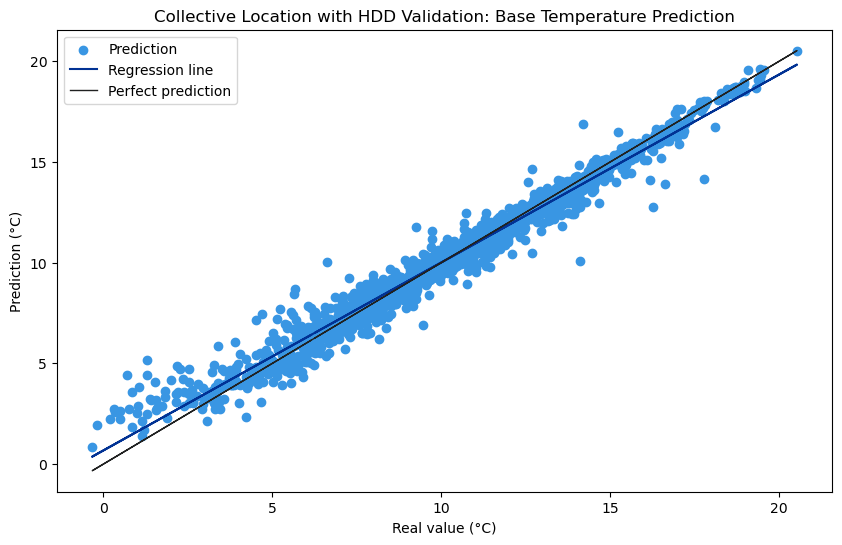

In [21]:
## Plot: real and predicted values

# Define source, x and y data
source = result
x1 = source['Real TB']
y1 = source['Prediction']

# Data check
print('max y= ', y1.max())
print('min y= ', y1.min())
print('max x= ', x1.max())
print('min x= ', x1.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
#ax.spines['bottom'].set_position('zero')

# Plot the data
plt.scatter(x1, y1, c='#3996e3', label='Prediction')

# Set axis label and title
plt.xlabel("Real value (°C)")
plt.ylabel("Prediction (°C)")
plt.title("Collective Location with HDD Validation: Base Temperature Prediction")

# Create regression line
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1+b , c='#013294', lw=1.5, label='Regression line')
print ('Regression line m and b: ', m,'and', b)

# Create perfect prediction line (m=1)
plt.plot(x1, x1 , c='#202121', lw=1, label='Perfect prediction')

ax.legend()

# Export graph
plt.savefig(r'Result\All-HDD_TB_train_Prediction.png', format="png", dpi=800)
print ('Prediction graph is saved')


max y=  4.043164596557617
min y=  -3.8657481193542482
max x=  20.52
min x=  -0.33
Error graph is saved


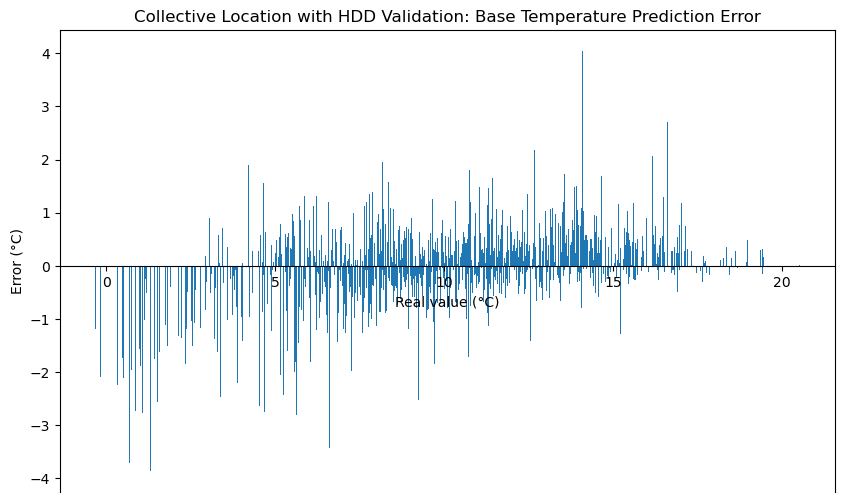

In [22]:
## Plot: prediction error and real value

# Define x and y data
# Error = real - prediction
x2 = source['Real TB']
y2 = source['Error']

# Data check
print('max y= ', y2.max())
print('min y= ', y2.min())
print('max x= ', x2.max())
print('min x= ', x2.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.bar(x2, y2, width=0.02)
#plt.xlim(0,610000)
#plt.ylim(-350000, 350000)

# Set axis label and title
plt.xlabel("Real value (°C)")
plt.ylabel("Error (°C)")
plt.title("Collective Location with HDD Validation: Base Temperature Prediction Error")

# Export graph
plt.savefig(r'Result\All-HDD_TB_train_Error.png', format="png", dpi=800)
print ('Error graph is saved')